# In which I brazenly defy Professor Ng and do his Neural Nets homework in Python instead of Matlab.

Weeks 4 & 5 of Andrew Ng's ML course on Coursera focuses on the mathematical model for neural nets, a common cost function for fitting them, and the forward and back propagation algorithms. Here I use the homework data set to learn about the relevant python tools.

>## Tools Covered:
- `LogisticRegression` for multiclass classification using one-vs-rest 
- `MLPClassifier` for mutliclass classification using a neural net model
- also `subplots` for dividing up matplotlib plots, `imshow` for visualizing matrices

# Visualizing the Data
*You are given a data set... that contains 5000 training examples of handwritten digits.*

*There are 5000 training examples, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is unrolled into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.*

*The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set... there is no zero index, we have mapped
the digit zero to the value ten. Therefore, a 0 digit is labeled as 10, while
the digits 1 to 9 are labeled as 1 to 9 in their natural order.*

OK so the first thing we want to do is read in this data and visualize the set of grayscale images. We can use numpy reshape to turn each "unrolled" vector back into a matrix, and then use some standard `matplotlib` to visualize them as a group.

In [297]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import pandas as pd
import numpy as np
import snips as snp
# snp.prettyplot(matplotlib)

In [298]:
cd hw-wk4

[WinError 2] The system cannot find the file specified: 'hw-wk4'
C:\Users\Sonya\Box Sync\Projects\course-machine-learning\hw-wk4


In [299]:
df_images = pd.read_csv("X.csv", header=None)
df_labels = pd.read_csv("y.csv", header=None)
df_labels.columns = ["label"]

Remember that each row is an individual image. Turns out of lots of pixels are 0...

In [300]:
df_images.head()  

0    1    2    3    4    5    6    7    8    9   ...   390  391  392  393  \
0    0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
1    0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
2    0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
3    0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   
4    0    0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0  0.0   

   394  395  396  397  398  399  
0  0.0  0.0  0.0  0.0  0.0    0  
1  0.0  0.0  0.0  0.0  0.0    0  
2  0.0  0.0  0.0  0.0  0.0    0  
3  0.0  0.0  0.0  0.0  0.0    0  
4  0.0  0.0  0.0  0.0  0.0    0  

[5 rows x 400 columns]

In [301]:
len(df_images)

5000

There are 5000 images, and to plot a single image we want to slice out that row from the dataframe, reshape the list (vector) of pixels into a 20x20 matrix, and then plot that matrix with `imshow`, like so...

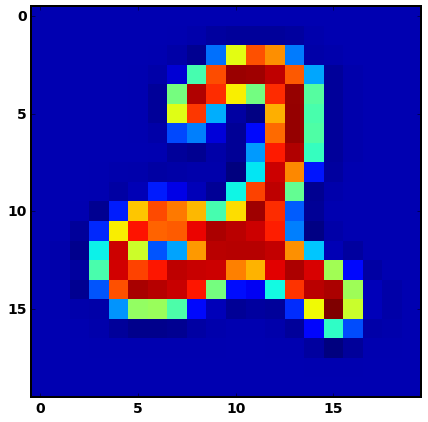

In [302]:
im = df_images.iloc[1020]  # picked a row at random
im = np.reshape(im, (20, 20), order="F")  #"F" means read/write by 1st index changing fastest, last index slowest. 
fig, ax = snp.newfig()
ax.imshow(im, interpolation="None")  # interpolation blurs to interpolate b/w pixels

That's obviously a loopy two. Looks good, wish I could write two's like that. Now we'll use numpy's random number capabilities to pick 100 rows at random and plot those images to get a general sense of the data set. We'll also use a grayscale map now instead of RGB.

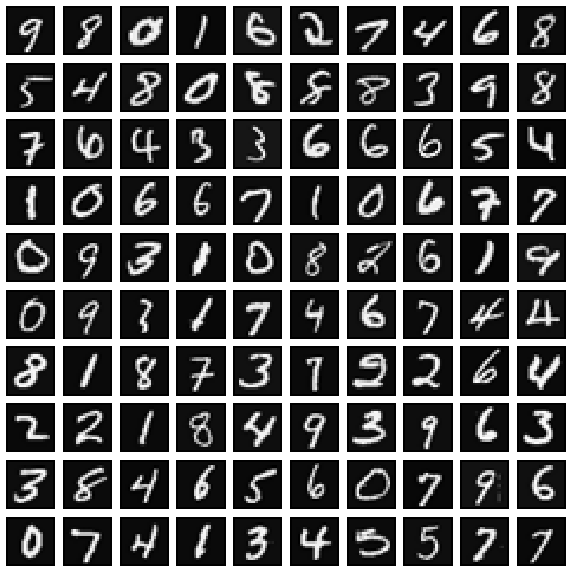

In [303]:
from numpy import random as rnd 
indxs = rnd.choice(df_images.index, 100, replace=False)  # take a random sample of size 100 from set of index values

 # Create a new figure with 100 axes objects inside it (subplots)
fig, axs = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(10,10)) 
axs = axs.flatten()  # The returned axs is actually a matrix holding the handles to all the subplot axes objects
graymap = plt.get_cmap("gray")

for i, indx in enumerate(indxs):
    im_mat = np.reshape(df_images.iloc[indx], (20, 20), order="F")
    axs[i].imshow(im_mat, cmap=graymap, interpolation="None")
    axs[i].xaxis.set_visible(False)  # Hide the axes labels for clarity
    axs[i].yaxis.set_visible(False) 

This doesn't look like the prettiest data set I've ever seen, but I don't see any numbers that a human would be likely to misidentify. I notice there is some variety in e.g. loopy versus not-loopy two's so I'd be curious to see how well we can handle those two sub-groups. 


# One-vs-Rest Logistic Regression for Multiclass Classification

So the point here is to do multiclass classification on this data set of hand written digits, but we'll try it using boring old Logistic regression and then we'll get fancier and try it with a neural net!  As a refresher on multi-class classification, recall that one approach was **"One vs. Rest"**. Here's an example: if you have three possible lables $\{1, 2, 3\}$, you can split the problem into three different binary classification problems: *1 or not 1*, *2 or not 2*, and *3 or not 3*. To excecute, for example, *1 or not 1* you take all the training data with labels 2 and 3 and map them to a label 0, then you execute the standard binary logistic regression on this data to get a hypothesis $h^{(1)}_\theta(x)$ whose decision boundary divides category 1 from the rest of the space. Rinse and repeat to get  $h^{(2)}_\theta(x)$ and  $h^{(3)}_\theta(x)$. Finally, **to classify a data point $x$ you assign it to whichever of the three classes gives the largest  $h^{(i)}_\theta(x)$.** 


We could follow this procedure manually. For instance I could take my vector `y` and make a copy of it where the 9s become 1s and every element that isn't a 9 becomes 0, then I could use my trusty 'ol `sklearn` tools `SGDClassifier` or `LogisticRegression` to train a binary classifier model on `X` and my modified `y`, and that classifier would tell me the probability to be "9" vs "not 9".  Then I could repeat this for every digit and I would have 10 binary classifiers. Then for any new data point I would compute the output of all 10 of these classifiers and use that to assign the point a digit label. 

But dear god, we aren't actually going to code all of that up! I just want you to know that we totally *could*. Instead we'll use the built-in multiclass capability of `LogisticRegression` which is doing exactly what I just described, but it doesn't bother you will all the gory details. You just need to instantiate the object with the `multi_class` attribute set to `"ovr"` for one-vs-rest.

In [304]:
from sklearn.linear_model import LogisticRegression
logregressor = LogisticRegression(solver="liblinear", multi_class="ovr")

In [305]:
train_y = df_labels["label"].as_matrix()  # To get the right vector-like shape call as_matrix on the single column
train_X = df_images.as_matrix()
logregressor.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Notice that it defaults to a reasonably strong regularization (the `C` attribute is inverse regularization strength). Let's see how it did on some of the training images using the lovely `predict` method for this guy. I'll actually draw the same kind of panel of examples as before, but now I'll print what digit it was classified as in the corner.

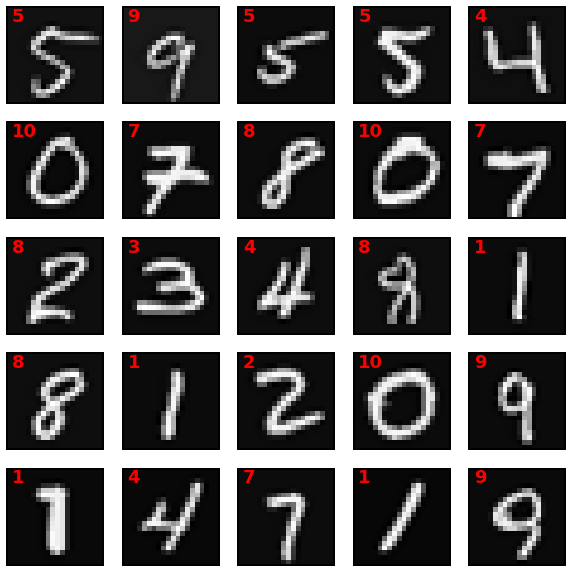

In [306]:
indxs = rnd.choice(df_images.index, 25, replace=False)  # take a random sample of size 100 from set of index values

 # Create a new figure with 100 axes objects inside it (subplots)
fig, axs = plt.subplots(5, 5, sharex=True, sharey=True, figsize=(10,10)) 
axs = axs.flatten()  # The returned axs is actually a matrix holding the handles to all the subplot axes objects
graymap = plt.get_cmap("gray")

for i, indx in enumerate(indxs):
    im_mat = np.reshape(df_images.iloc[indx], (20, 20), order="F")
    labl = str(logregressor.predict(df_images.iloc[indx].reshape(1, -1))[0])  
    
    # Plot the image along with the label it is assigned by the fitted model.
    axs[i].imshow(im_mat, cmap=graymap, interpolation="None")
    axs[i].annotate(labl, xy=(0.05, 0.85), xycoords="axes fraction", color="red", fontsize=18)
    axs[i].xaxis.set_visible(False)  # Hide the axes labels for clarity
    axs[i].yaxis.set_visible(False) 

That's not too shabby - it's misclassified a couple things but the handwriting isn't great so lets cut him some slack! We can quantify exactly how well it did on the training set by running `predict` on the full set `X` and comparing the results to the real `y`.

In [307]:
df_labels["assigned"] = logregressor.predict(train_X)
df_labels["success"] = (df_labels["assigned"] == train_y)
df_labels = df_labels.rename(columns={0: "label"})  # Just to make it look nicer
df_labels.head()

label  assigned success
0     10        10    True
1     10        10    True
2     10        10    True
3     10        10    True
4     10        10    True

What I want to do now is split the `y` dataframe into groups based on the correct digit label, then for each group I want to execute a function that counts the fraction of successful predictions by the logistic regression, and see the results of this for each group. This is almost word-for-word what a `pandas` group by operation is for! From the [official `Groupby` documentation](http://pandas.pydata.org/pandas-docs/stable/groupby.html):

>By “group by” we are referring to a process involving one or more of the following steps
- Splitting the data into groups based on some criteria
- Applying a function to each group independently
- Combining the results into a data structure

In [308]:
for name, group in df_labels.groupby("label"):
    frac = sum(group["success"])/len(group)
    print("Success rate for labeling digit %i was %f " %(name, frac))

Success rate for labeling digit 1 was 0.984000 
Success rate for labeling digit 2 was 0.918000 
Success rate for labeling digit 3 was 0.906000 
Success rate for labeling digit 4 was 0.956000 
Success rate for labeling digit 5 was 0.912000 
Success rate for labeling digit 6 was 0.976000 
Success rate for labeling digit 7 was 0.948000 
Success rate for labeling digit 8 was 0.926000 
Success rate for labeling digit 9 was 0.922000 
Success rate for labeling digit 10 was 0.992000 


This really isn't too bad of a success probability for our simple model. Remember that this tool only fits a simple logistic hypothesis of the form $h_\theta(x) = \frac{1}{1+\exp(-\theta^Tx)}$ which depends on the simple linear regression quantity $\theta^Tx$. This means that we can't expect anything too complicated in terms of decision boundaries for our binary classifiers until we've added more features (like polynomial transforms of our original pixels), or until we move to a more sophisticated model (like a neural net... \*winkwink\*). 

## Visualizing Misclassification Errors
Just out of curiosity, let's visualize what "kind" of mistake our model is making - what digits is a real three most likely to be mislabeled as, for example.

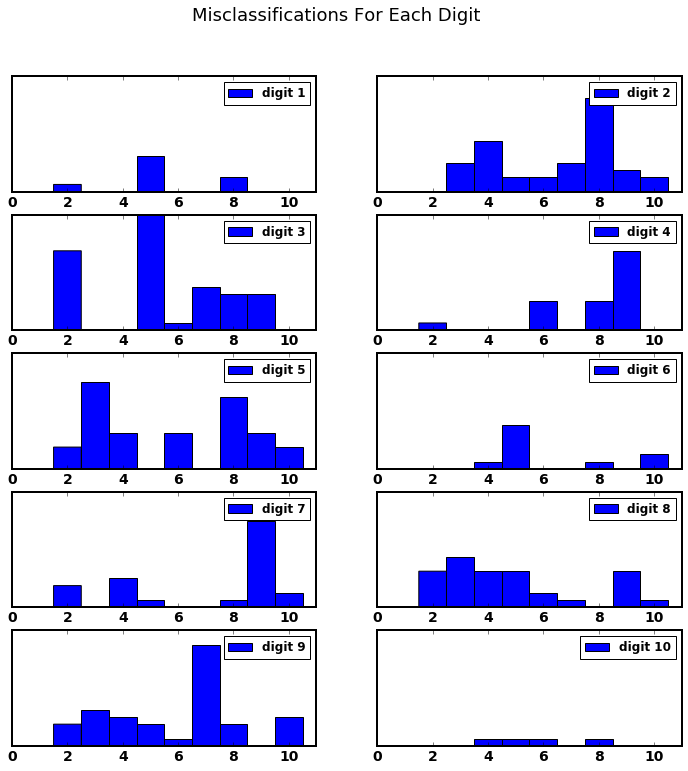

In [309]:
fig, axs = plt.subplots(5, 2, sharex=False, sharey=True, figsize=(12,12))
fig.suptitle("Misclassifications For Each Digit", fontsize=18)
axs = axs.flatten()

for name, group in df_labels.groupby("label"):
    group = group[group["assigned"] != name]  # Get rid of correct predictions - they swamp the histogram!
    ax = axs[name-1]  # How convenient :)
    ax.hist(group["assigned"], label=("digit %i" %name), bins=np.arange(1, 11, 1)+0.5)  # Shift the bins to get labels aligned
    ax.set_xlim([0, 11])
    ax.legend(loc="upper right")
    ax.yaxis.set_visible(False)


For a lot of digits there isn't a that strong of a trend for confusing it with a particular other digit, although you can see that 9 and 7 have a bit of cross talk with one another, as do 3 and 5 - these are mix-ups a human would probably be most likely to make. Interestingly 2 is very likely to get misclassified as 8, but not vice versa. 


## Sanity Check: Using a Different Solver
It is possible that some of the suboptimal performance is not the limitation of the model, but rather a poor execution of fitting the model, such as gradient descent not converging effectively to the minimum. In this case the default solver for `LogisticRegression` is coordinate descent, but we could ask it to use a different solver and see if we get something better. We also could adjust the regularization parameter if we had a suspicion of over or underfitting.

Let's try with a different solver:

In [310]:
logregressor = LogisticRegression(solver="sag", multi_class="ovr", max_iter = np.ceil(10**6 / len(train_y)))
logregressor.fit(train_X, train_y)
df_labels["success"] = (train_y == logregressor.predict(train_X))

for name, group in df_labels.groupby("label"):
    frac = sum(group["success"])/len(group)
    print("Success rate for labeling digit %i was %f " %(name, frac))

Success rate for labeling digit 1 was 0.986000 
Success rate for labeling digit 2 was 0.918000 
Success rate for labeling digit 3 was 0.908000 
Success rate for labeling digit 4 was 0.954000 
Success rate for labeling digit 5 was 0.916000 
Success rate for labeling digit 6 was 0.978000 
Success rate for labeling digit 7 was 0.950000 
Success rate for labeling digit 8 was 0.920000 
Success rate for labeling digit 9 was 0.924000 
Success rate for labeling digit 10 was 0.992000 


OK this is reassuring - the Stochastic Average Gradient Descent (`sag`) algorithm for fiting the binary classifiers did almost exactly the same as our initial attempt with the Coordinate Descent algorithm. This is also cheating a bit, but Professor Ng says in the homework PDF that we should be getting about a 95% average success rate, which we are pretty close to I would say. 

It seems likely now that the limitations are inherent to our model, so let's try something different.... 

# Neural Nets for Multiclass Classification

According to Professor Ng, this is a computationally preferable way to get more complexity in our decision boundaries as compared to just adding more features to our simple logistic regression. Remember that in a neural net the first (bottommost) layer of units just spit out our features (the vector `x`). For us each data point has 400 features (one for each pixel) so our bottom most layer should have 401 units - don't forget the constant "bias" unit. Also since we are doing a multiclass classification with 10 labels we want out topmost layer to have 10 units, each of which outputs a probability like 4 vs. not 4, 5 vs. not 5 etc. In this homework we are instructed to sandwhich these input and output layers around a single hidden layer with 25 units. 
<img src="images/hw-wk4/neural_net.png"></img>

Now the trick is to decide what python package to use to play with neural nets. When I googled around about this there were a [lot of opinions and quite a large number of contenders](https://www.quora.com/What-is-the-best-neural-network-library-for-Python). But from what I gather, if you are doing small scale applications with mostly out-of-the-box algorithms then it's not going to matter much. In that case I'll just stick with `sklearn`, thankyouverymuch. Per usual, the [official documentation for scikit-learn's neural net capability](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) is excellent. They mention the following helpful tips:

>The advantages of Multi-layer Perceptron are:
- Capability to learn non-linear models.
- Capability to learn models in real-time (on-line learning) using partial_fit.

>The disadvantages of Multi-layer Perceptron (MLP) include:
- MLP with hidden layers have a non-convex loss function where there exists more than one local minimum. Therefore different random weight initializations can lead to different validation accuracy.
- MLP requires tuning a number of hyperparameters such as the number of hidden neurons, layers, and iterations.
- MLP is sensitive to feature scaling.

To summarize - don't forget to scale features, watch out for local minima, and try different hyperparameters (number of layers and neurons / layer).

## Sklearn's `MLPClassifier` Neural Net
The kind of neural network that is implemented in `sklearn` is a Multi Layer Perceptron (MLP). The class `MLPClassifier` is the tool to use when you want a neural net to do classification for you - to train it you use the same old `X` and `y` inputs that we fed into our `LogisticRegression` object. Note that first I needed to get a newer version of `sklearn` to access MLP (as simple as `conda update scikit-learn` since I use the Anaconda Python distribution. 

In [314]:
from sklearn.neural_network import MLPClassifier

### Cost Function and Fitting with Backprop

This class uses forward propagation to compute the state of the net and from there the cost function, and uses back propagation as a step to compute the partial derivatives of the cost function. However the actual minimization algorithm which will rely on the calculated $J$ and it's partials can be specified in the `solver` attribute of the object - let's just stick with gradient descent since we are familiar with it:

In [315]:
classifier = MLPClassifier(solver="sgd")

And let's just remind ourselves what actually goes on when this thing is being trained ...

### A full algorithm for getting $J(\theta)$ and it's partials at a point in parameter space $\theta$:

- For each training point $(x, y)$:
    - Use forward propagation to compute all the activations of the neurons for that input $x$
    - Plug the top layer activations $h_\theta(x) = a^{(K)}$ into the cost function to get the cost for that training point
    - Use back propagation and the computed $a^{(K)}$ to compute all the errors of the neurons for that training point
    - Use all the computed errors and activations to calculate the contribution to each of the partials from that training point 
- Sum the costs of the training points to get the cost function at $\theta$
- Sum the contributions of the training points to each partial to get each complete partial at $\theta$
- For the full cost, add in the regularization term which just depends on the $\Theta^{(l)}_{ij}$'s
- For the complete partials, add in the piece from the regularization term $\lambda \Theta^{(l)}_{ij}$

In class we discussed a particular form of the cost function $J(\theta)$ for neural nets which was a generalization of the typical log-loss for binary logistic regression. The docs for `MLPClassifier` say that it always uses the [Cross-Entropy" loss](http://neuralnetworksanddeeplearning.com/chap3.html#introducing_the_cross-entropy_cost_function), which looks like what we discussed in class although Professor Ng never used this name for it. To recap: For a single training data point, $(\vec{x},\vec{y})$, it computes the conventional log-loss element-by-element for each of the $K$ elements of $\vec{y}$ and then sums these. For the full loss it simply sums these contributions from all the training points.

\begin{align}
J_{\textrm{neural}}(\theta) = \sum_{k=1}^KJ_k(\theta) = \sum_{k=1}^K\bigg[\frac{1}{m}\sum_1^m\frac{1}{2}\textrm{cost}\big(h_\theta(x^{(i)})_k, y^{(i)}_k\big)\bigg].
\end{align}



### Architecture and Other Specifications
Now we need to specify a few more things about our model and the way it should be fit. First of all, we need to give it a fixed architecture for the net. In class Professor Ng gives us these rules of thumb:

- the number of input units will be the number of features
- for multiclass classification the number of output units will be the number of labels
- try a single hidden layer, or if more than one then each hidden layer should have the same number of units
- the more units in a hidden layer the better, try the same as the number of input features up to twice or even three or four times that

Each training point (a 20x20 image) has 400 features, but that is a lot of neurons so let's try a single hidden layer with only 40 units (in the official homework Professor Ng suggest we use 25). Furthermore, the official doc notes
> Suppose there are n training samples, m features, k hidden layers, each containing h neurons - for simplicity, and o output neurons. The time complexity of backpropagation is $O(n\cdot m \cdot h^k \cdot o \cdot i)$, where i is the number of iterations. Since backpropagation has a high time complexity, it is advisable to start with smaller number of hidden neurons and few hidden layers for training.

`MLPClassifier` is smart enough to figure out how many output units you need based on the dimension of the`y`'s you feed it. We also need to specify the "activation" function that all these neurons will use - this means the transformation a neuron will apply to it's weighted input. In class we have been using the sigmoid logistic function to compute activations so we'll continue with that.

In [316]:
classifier.hidden_layer_sizes = (40,)  # Remember funny notation for tuple with single element
classifier.activation = "logistic"

We don't have to provide initial weights to this helpful tool - it does random initialization for you when it does the fitting.
As a final note, this object does default to doing $L2$ penalized fitting with a strength of 0.0001. We'll just leave that alone for now. Let us fit!

In [317]:
classifier.fit(train_X, train_y)

C:\Users\Sonya\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

## Visualizing the Cost Function Trajectory
Oho! This didn't really work out of the box, we weren't able to converge even after hitting the maximum number of iterations in gradient descent (which was the default of 200). To get a better idea of how the optimization is proceeding you could re-run this fit with `verbose=True` and watch what happens to the loss - the `verbose` attribute is available for lots of `sklearn` tools and is handy in situations like this as long as you don't mind spamming stdout. But I will let you in on super-secret trick for this particular tool: **`MLPClassifier` has an attribute that actually stores the progression of the loss function during the fit**. It's called `loss_curve_` and for some baffling reason it isn't mentioned in the documentation. So, let's see what was actually happening during this failed fit.

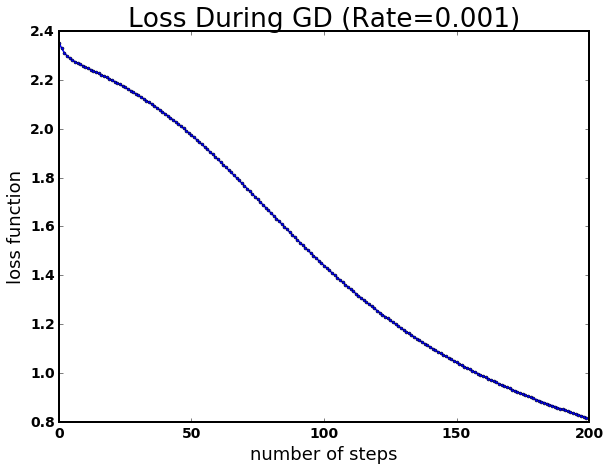

In [318]:
snp.prettyplot(matplotlib)
fig, ax = snp.newfig()
ax.plot(classifier.loss_curve_)
snp.labs("number of steps", "loss function", "Loss During GD (Rate=0.001)")

OK so our loss *is* decreasing nicely - but it's just happening very slowly. We could increase the `max_iter` but that slows down our algorithm so first let's try letting it step through parameter space more quickly by increasing the learning rate. Notice that the attribute `learning_rate` is `constant` (which means it won't adjust itself as the algorithm proceeds), and it's `learning_rate_initial` value is 0.001. Let's adjust it to 1

In [319]:
classifier.learning_rate_init = 1
classifier.fit(train_X, train_y)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40,), learning_rate='constant',
       learning_rate_init=1, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

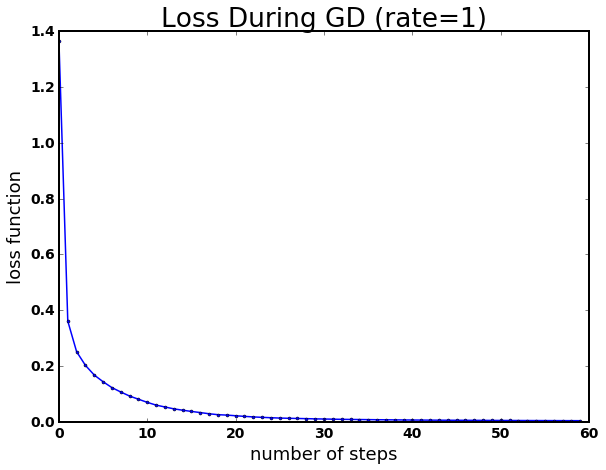

In [320]:
fig, ax = snp.newfig()
ax.plot(classifier.loss_curve_)
snp.labs("number of steps", "loss function", "Loss During GD (rate=1)")

OK no warning about convergence this time, and the plot makes it clear that our loss has dropped dramatically and then evened out, so let's check the fitted algorithm's performance on our training set:

In [321]:
df_labels["success"] = (train_y == classifier.predict(train_X))

for name, group in df_labels.groupby("label"):
    frac = sum(group["success"])/len(group)
    print("Success rate for labeling digit %i was %f " %(name, frac))

Success rate for labeling digit 1 was 1.000000 
Success rate for labeling digit 2 was 1.000000 
Success rate for labeling digit 3 was 1.000000 
Success rate for labeling digit 4 was 1.000000 
Success rate for labeling digit 5 was 1.000000 
Success rate for labeling digit 6 was 1.000000 
Success rate for labeling digit 7 was 1.000000 
Success rate for labeling digit 8 was 1.000000 
Success rate for labeling digit 9 was 1.000000 
Success rate for labeling digit 10 was 1.000000 


Holy crap, this machine is pretty much sentient. It could probably pass the Turing Test or something. But you know how when something is too good to be true then it probably isn't... yeah, about that. 

## Overfitting Sanity Check
The 100% success rate for this net is a little scary. A better approach would have been to reserve a random sample of our training data points and leave them out of the fitting, then see how well the fitted model does on those "new" points. Let's try setting aside 10% of our data (500 images), fitting with the remaining 90% and then see how it does.

In [357]:
indxs = rnd.choice(df_images.index, 500, replace=False)  # take a random sample of size 1000 from set of index values

# To be kept in reserve
reserve_X = df_images.iloc[indxs].copy()  # Avoid returning a view to original df
reserve_y = df_labels.iloc[indxs].copy()

# To be used for fitting
train_X = df_images.drop(indxs)
train_y = df_labels.drop(indxs)

classifier.fit(train_X.as_matrix(), train_y["label"].as_matrix())

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(40,), learning_rate='constant',
       learning_rate_init=1, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [358]:
reserve_y["success"] = (reserve_y["label"].values == classifier.predict(reserve_X.as_matrix()))

for name, group in reserve_y.groupby("label"):
    frac = sum(group["success"])/len(group)
    print("Success rate for labeling digit %i was %f " %(name, frac))

Success rate for labeling digit 1 was 0.918367 
Success rate for labeling digit 2 was 0.958333 
Success rate for labeling digit 3 was 0.945455 
Success rate for labeling digit 4 was 0.938776 
Success rate for labeling digit 5 was 0.950000 
Success rate for labeling digit 6 was 0.950820 
Success rate for labeling digit 7 was 0.921053 
Success rate for labeling digit 8 was 0.853659 
Success rate for labeling digit 9 was 0.918367 
Success rate for labeling digit 10 was 0.980000 


Ahhhh, it looks like maybe we were overfitting when we got our previous 100% accuracy, this performance is more in line with that of the standard one-vs-rest logistic regression we started with.

# Visualizing a Net

The documentation explains how you can get a look at the net that you just trained :
> `coefs_` is a list of weight matrices, where weight matrix at index i represents the weights between layer i and layer i+1. `intercepts_` is a list of bias vectors, where the vector at index i represents the bias values added to layer i+1.

So we if we look at the first element of `coefs_` it should be the matrix $\Theta^{(1)}$ which says how the 400 input features `x` should be weighted to feed into the 40 units of the single hidden layer. Similarly the first element of `intercepts_` should be a vector with 40 elements that says what constant value was added the weighted input for each of the units of the single hidden layer.

In [332]:
np.size(classifier.coefs_[0])

16000

In [333]:
len(classifier.intercepts_[0])

40

One helpful way to visualize this net is to plot the weighting matrices $\Theta^{(l)}$ as grayscale "pixelated" images.

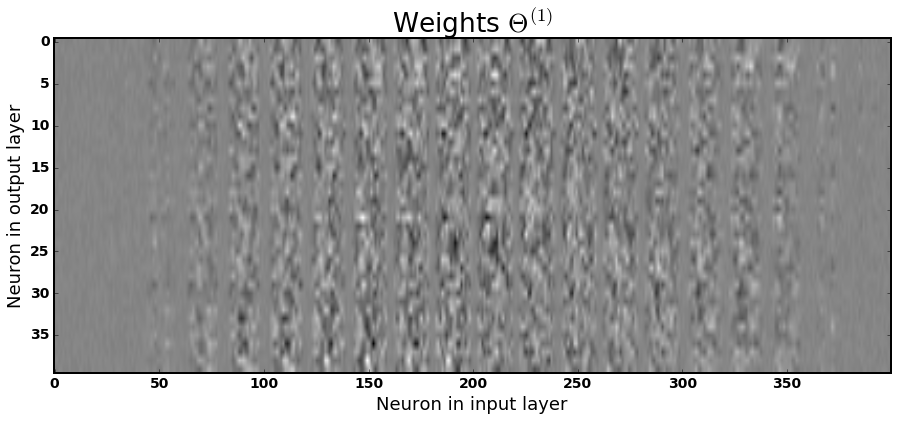

In [334]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.imshow(np.transpose(classifier.coefs_[0]), cmap=plt.get_cmap("gray"), aspect="auto")
snp.labs("Neuron in input layer", "Neuron in output layer", "Weights $\Theta^{(1)}$")

How to interpet such a visualization? First, on gray scale large negative numbers are black, large positive numbers are white, and numbers near zero are gray. Now we know that each neuron is taking it's weighted input and applying the logistic transformation on it, which outputs 0 for inputs much less than 0 and outputs 1 for inputs much greater than 0. So, for instance, if a particular weight $\Theta^{(l)}_{ij}$ is large and negative it means that neuron $i$ is having its output strongly pushed to zero by the input from neuron $j$ of the underlying layer. If a pixel is gray then that means that neuron $i$ isn't very sensitive to the output of neuron $j$ in the layer below it. In the above image that seems to be the case for the very first (0 through 40ish) and very last pixels (370ish through 400), which would be those on the top and bottom border of the images. This makes sense since that region of the images is usually blank and doesn't carry much information. Similarly, the blank pixels on the left and right borders also shouldn't have much weight, and that manifests as the periodic gray vertical bands.

Another really neat way to visualize your net is to plot an image of what makes each hidden neuron "fire", that is, what kind of input vector causes the hidden neuron to activate near 1. In the $\Theta^{(1)}$ which we displayed graphically above, the 400 input weights for a single hidden neuron correspond to a single row of the weighting matrix. For a given hidden neuron we can reshape these input weights back into the original 20x20 form of the input images and plot the resulting image. For instance, for the seventeenth hidden neuron:

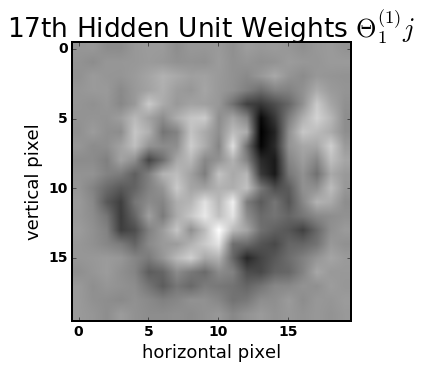

In [351]:
hidden_2 = np.transpose(classifier.coefs_[0])[16]  # Pull weightings on inputs to the 2nd neuron in the first hidden layer

fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(np.reshape(hidden_2, (20,20)), cmap=plt.get_cmap("gray"), aspect="auto")
snp.labs("horizontal pixel", "vertical pixel", "17th Hidden Unit Weights $\Theta^{(1)}_1j$")

So it looks like this hidden neuron is activated by strokes in the botton left of the page, and deactivated by strokes in the top right. We might expect this guy to fire on a digit 6, but not so much on a 9.

# Summary
Multiclass classification can be done with one-vs-rest approach using `LogisticRegression` where you can specify the numerical solver, this defaults to a reasonable regularization strength. Alternately multiclass classification can be done with `sklearn`'s neural net tool `MLPClassifier` which uses forward propagation to compute the state of the net and from there the cost function, and uses back propagation as a step to compute the partial derivatives of the cost function. You also need to specify the solver for this class, and the specific net architecture must be chosen by the user. `MLPClassifier` has the handy `loss_curve_` attribute that actually stores the progression of the loss function during the fit to give you some insight into the fitting process. A neat way to visualize a fitted net model is to plot an image of what makes each hidden neuron "fire", that is, what kind of input vector causes the hidden neuron to activate near 1.